In [1]:
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
habr_metadata = pd.read_csv('parsing_habr/habr_metadata.csv')

# Работаем с данными


### Цель
Проианализировать по метаданным частоту появления open source технологий в статьях русскоязычного сообщества Хабр, посмотреть динамику упоребления и какие еще технлологии упоминаются в тегах к статьям.

### Задачи


*   проанализировать структуру html страниц хабра
*   создать функцию обработчик для сбора метаданных по статьям в диапазоне 2012-2024 год
*   провести предобработку и разведовачный анализ данных
* программа максимум сделать регрессионный анализ и анализ времянных рядов

### Гипотеза
Резкий скачок по упоминаниям этих инструментов случился в 2017-2018 годах, потому что бизнес и компании перешли на понимание, что большие данные необходимо где-то хранить и обрабатывать.
А второй резкий скачок случился в 2022 году, так как в России нет ПО, которое могло бы заменить зарубежные решения. В итоге сейчас мы пользуемся зарубежными решениями, но с открытым исходным кодом и доделываем под себя.

### Описание
Парсинг метаданных статей, в которых есть названия open source технологий, которые отвечают за работу DWH хранилищ и обеспечивают доставку больших данных внутри информационных систем (приложений, сайтов, внутренних ИС).

Мне нужны статьи в названиях или тегах, которых есть kafka, spark, hadoop, airflow. Вдохновилась я [вот этой статьей ](https://habr.com/ru/articles/346198/)и идеей, что такой анализ позволит дать оценку open sorce решений после 2022 года, как решениям, которые закрепились на рыноке ПО в России.

Так эта часть анализа пригодиться для обоснования инструментов, которые я использую в дипломе. А там как раз kafka, spark, airflow.

In [3]:
data = pd.read_pickle('checkpoint1.pkl')

for i in range(2,6):
    a = pd.read_pickle('checkpoint'+str(i)+'.pkl')
    for k in a:
        data.append(k)
        # print(k)


In [4]:
habr_metadata = pd.DataFrame(data)

In [5]:
habr_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        778 non-null    object
 1   title      778 non-null    object
 2   time       778 non-null    object
 3   views      778 non-null    object
 4   tags       778 non-null    object
 5   hub        778 non-null    object
 6   bookmarks  778 non-null    object
 7   comments   778 non-null    object
dtypes: object(8)
memory usage: 48.8+ KB


In [6]:
habr_metadata['views'].unique()

array(['68K', '47K', '35K', '93K', '13K', '30K', '26K', '4.6K', '12K',
       '56K', '479K', '52K', '63K', '6.1K', '22K', '9.6K', '17K', '4K',
       '11K', '16K', '8.5K', '5.4K', '33K', '8K', '6.4K', '23K', '21K',
       '24K', '122K', '18K', '71K', '7.5K', '1.8K', '27K', '5.7K', '94K',
       '6.8K', '7.4K', '10K', '20K', '4.2K', '14K', '5.1K', '46K', '6K',
       '7K', '7.9K', '2.6K', '45K', '175K', '19K', '8.2K', '9.3K', '2.2K',
       '70K', '5K', '4.9K', '88K', '239K', '43K', '1.9K', '240K', '2.1K',
       '36K', '15K', '32K', '3.9K', '2.3K', '3.2K', '388K', '61K', '5.6K',
       '28K', '6.9K', '332K', '50K', '57K', '8.7K', '9.7K', '25K', '2.5K',
       '7.3K', '7.7K', '7.2K', '333K', '3.7K', '5.3K', '7.8K', '2.9K',
       '3.1K', '76K', '8.3K', '130K', '9.9K', '9K', '2.8K', '9.5K', '34K',
       '4.1K', '6.3K', '8.9K', '3.4K', '1.6K', '7.6K', '108K', '104K',
       '1.5K', '131K', '4.5K', '39K', '1.1K', '3.8K', '6.5K', '8.4K',
       '29K', '265K', '38K', '2.7K', '3.3K', '5.5K',

In [7]:

habr_metadata['views']  = habr_metadata['views'].replace(r'[K]', '000', regex=True).replace(r'\D', '', regex = True)
habr_metadata['views'] = habr_metadata['views'].astype(int)
habr_metadata['time'] = pd.to_datetime(habr_metadata['time'])
habr_metadata[['bookmarks', 'comments']] = habr_metadata[['bookmarks', 'comments']] .apply(pd.to_numeric)

In [8]:
habr_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   url        778 non-null    object             
 1   title      778 non-null    object             
 2   time       778 non-null    datetime64[ns, UTC]
 3   views      778 non-null    int64              
 4   tags       778 non-null    object             
 5   hub        778 non-null    object             
 6   bookmarks  778 non-null    int64              
 7   comments   778 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 48.8+ KB


In [9]:
habr_metadata.describe()

,views,bookmarks,comments
count,778.000000,778.000000,778.000000
mean,40628.257069,55.601542,7.033419
std,45414.264003,85.851706,11.582569
min,357.000000,0.000000,0.000000
25%,15000.000000,16.000000,0.000000
50%,29000.000000,33.000000,3.000000
75%,54000.000000,63.000000,9.000000
max,479000.000000,958.000000,109.000000


## Предобработка текста

In [3]:
import spacy
from spacy.lang.ru import Russian
nlp = spacy.load("ru_core_news_lg")
import re

In [11]:
def clean_hub_list(hub_list):
    return [re.sub(r'[^\w\s]', '', j).lower() for j in hub_list]

habr_metadata['hub'] = habr_metadata['hub'].apply(clean_hub_list)

## лемматизируем текст

In [12]:
def lemma_habr(column):
    lemma = []
    for index, row in habr_metadata.iterrows():
        # Объединяем список слов в строку
        text = " ".join(row[column])
        doc = nlp(text)
        lemma.append([token.lemma_ for token in doc])
    return lemma

habr_metadata['title_lemma'] = lemma_habr('title')
habr_metadata['tags_lemma'] = lemma_habr('tags')
habr_metadata['lemma_hub'] = lemma_habr('hub')

## Удаляем стоп слова

In [31]:
# !wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
with open ("stop_ru.txt", "r") as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]


In [35]:
def remove_stop_words(token_list):

    return [word for word in token_list if word.lower() not in rus_stops and not re.fullmatch(r'\d+', word)]
habr_metadata['title_lemma'] = habr_metadata['title_lemma'].apply(remove_stop_words)
habr_metadata['tags_lemma'] = habr_metadata['tags_lemma'].apply(remove_stop_words)
habr_metadata['lemma_hub'] = habr_metadata['lemma_hub'].apply(remove_stop_words)

## Теперь посчитаем частоту возникновения тем связанных с kafka, spark, airflow

In [28]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn

# зададим стиль для графиков 
plt.style.use('seaborn-v0_8-darkgrid')  # Можно использовать любую другую палитру
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
sns.set_palette("pastel")

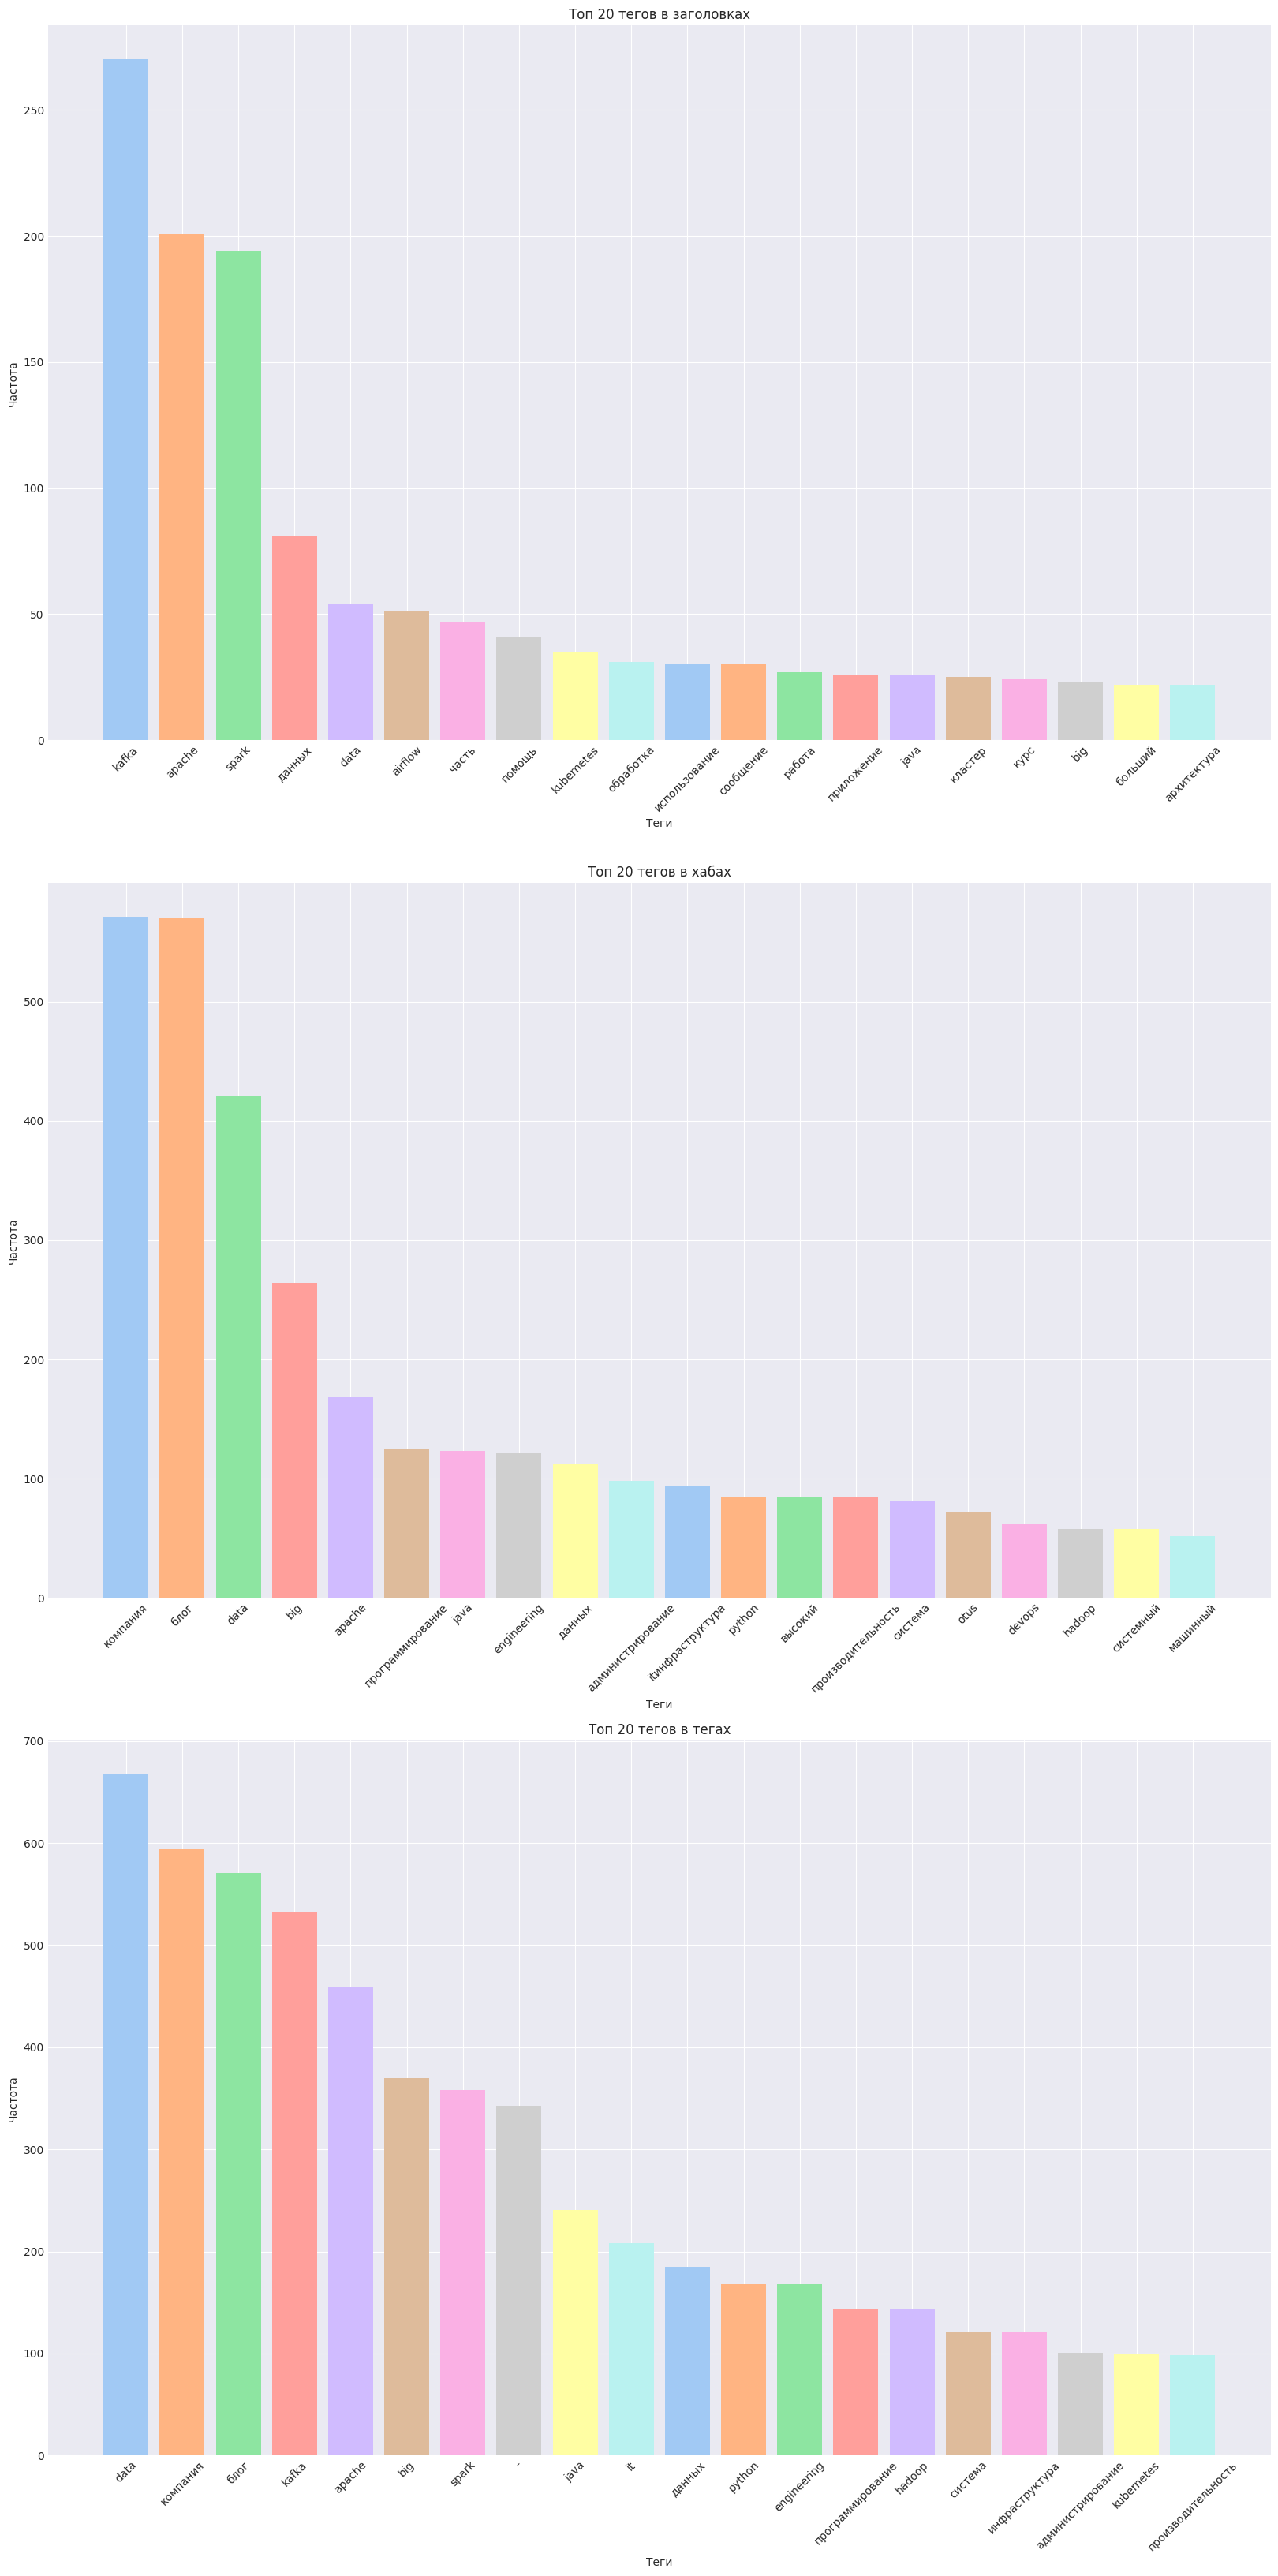

In [33]:
# Отрисуем 3 диаграммы по распределению топ 20 слов в тексте нужно сделать три subplots
freq_all_title = FreqDist(habr_metadata['title_lemma'].sum())
freq_all_hub = FreqDist(habr_metadata['lemma_hub'].sum())
freq_all_tags = FreqDist(habr_metadata['tags_lemma'].sum())


fig, axes = plt.subplots(3, 1, figsize=(20, 40))

tags1, counts1 = zip(*freq_all_title.most_common(20))
axes[0].bar(tags1, counts1, color=sns.color_palette())
axes[0].set_title("Топ 20 тегов в заголовках")
axes[0].set_xlabel("Теги")
axes[0].set_ylabel("Частота")
axes[0].tick_params(axis='x', rotation=45)

tags2, counts2 = zip(*freq_all_hub.most_common(20))
axes[1].bar(tags2, counts2, color=sns.color_palette())
axes[1].set_title("Топ 20 тегов в хабах")
axes[1].set_xlabel("Теги")
axes[1].set_ylabel("Частота")
axes[1].tick_params(axis='x', rotation=45)

tags3, counts3 = zip(*freq_all_tags.most_common(20))
axes[2].bar(tags3, counts3, color=sns.color_palette())
axes[2].set_title("Топ 20 тегов в тегах")
axes[2].set_xlabel("Теги")
axes[2].set_ylabel("Частота")
axes[2].tick_params(axis='x', rotation=45)

In [135]:
from matplotlib.ticker import MultipleLocator

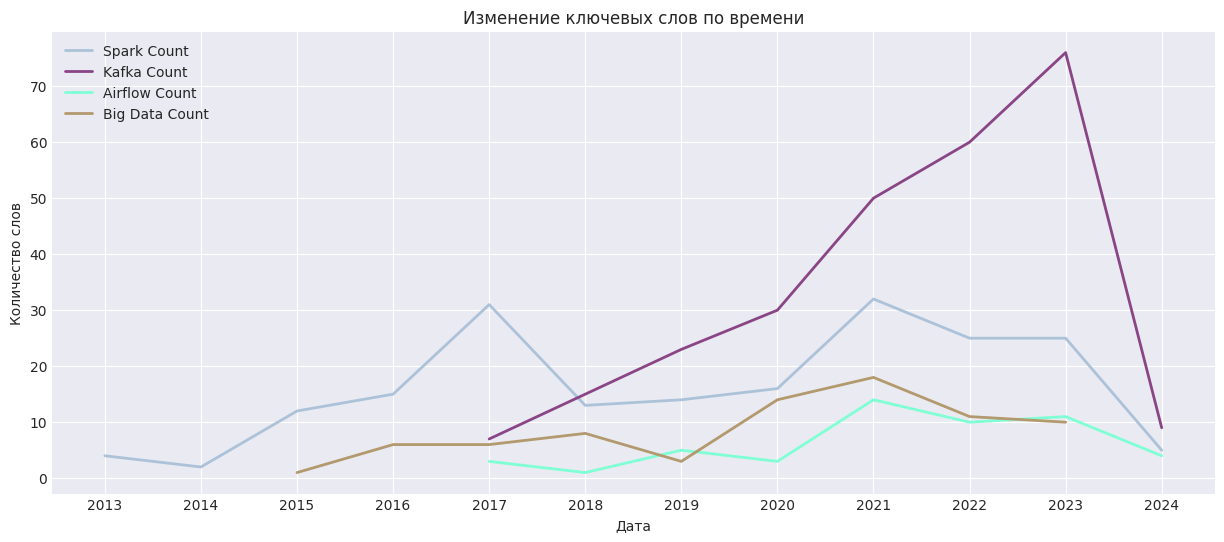

In [139]:
# мне нужно сгруппировать по году и месяцу частоту появления то есть count слова kafka spark и airlfow и большие данные и big data наверное или в title или hub или в тегах


exploded_df = habr_metadata.explode('title_lemma')
spark_counts = exploded_df[exploded_df['title_lemma'] == 'spark'] \
    .groupby('year')['title_lemma'] \
    .count() \
    .reset_index(name ='spark_count')

# spark_counts = spark_counts.set_index('year')

kafka_counts = exploded_df[exploded_df['title_lemma'] == 'kafka'] \
    .groupby('year')['title_lemma'] \
    .count() \
    .reset_index(name='kafka_count')

# kafka_counts = kafka_counts.set_index('year')


airflow_counts = exploded_df[exploded_df['title_lemma'] == 'airflow'] \
    .groupby('year')['title_lemma'] \
    .count() \
    .reset_index(name='airflow_count')

# airflow_counts = airflow_counts.set_index('year')


big_data_counts = exploded_df[exploded_df['title_lemma'].isin(['big', 'data', 'большие'])] \
    .groupby('year')['title_lemma'] \
    .count() \
    .reset_index(name='big_data_count')

# Строим lineplot
plt.figure(figsize=(15, 6))  # Устанавливаем размер графика
plt.plot(spark_counts['year'], spark_counts['spark_count'], color='#acc2d9', linewidth=2, label='Spark Count') #linestyle='-' рисует линии
plt.plot(kafka_counts['year'], kafka_counts['kafka_count'], color='#894585', linewidth=2, label='Kafka Count') #linestyle='-' рисует линии
plt.plot(airflow_counts['year'], airflow_counts['airflow_count'], color = '#7FFFD4',  linewidth=2, label='Airflow Count') #linestyle='-' рисует линии
plt.plot(big_data_counts['year'], big_data_counts['big_data_count'], color = '#b2996e',  linewidth=2, label='Big Data Count') #linestyle='-' рисует линии

ax = plt.gca()  # Получаем текущие оси
ax.xaxis.set_major_locator(MultipleLocator(1))

plt.xlabel("Дата")
plt.ylabel("Количество слов")
plt.title("Изменение ключевых слов по времени")
plt.grid(True) # Добавляем сетку для лучшей читаемости
plt.legend()
plt.show()



## Теперь посмотрим как менялись графики по просмотрам и закладкам по всему датасету

In [165]:

habr_metadata['year'] = habr_metadata.time.dt.year
habr_metadata['month'] = habr_metadata.time.dt.month
habr_metadata['day'] = habr_metadata.time.dt.day


sum_by_metadata = habr_metadata \
    .groupby(['year']) \
    .agg(sum_of_views = ('views', 'sum'),
         sum_of_bookmarks = ('bookmarks', 'sum'),
         sum_of_comments = ('comments', 'sum')) \
    .reset_index() 



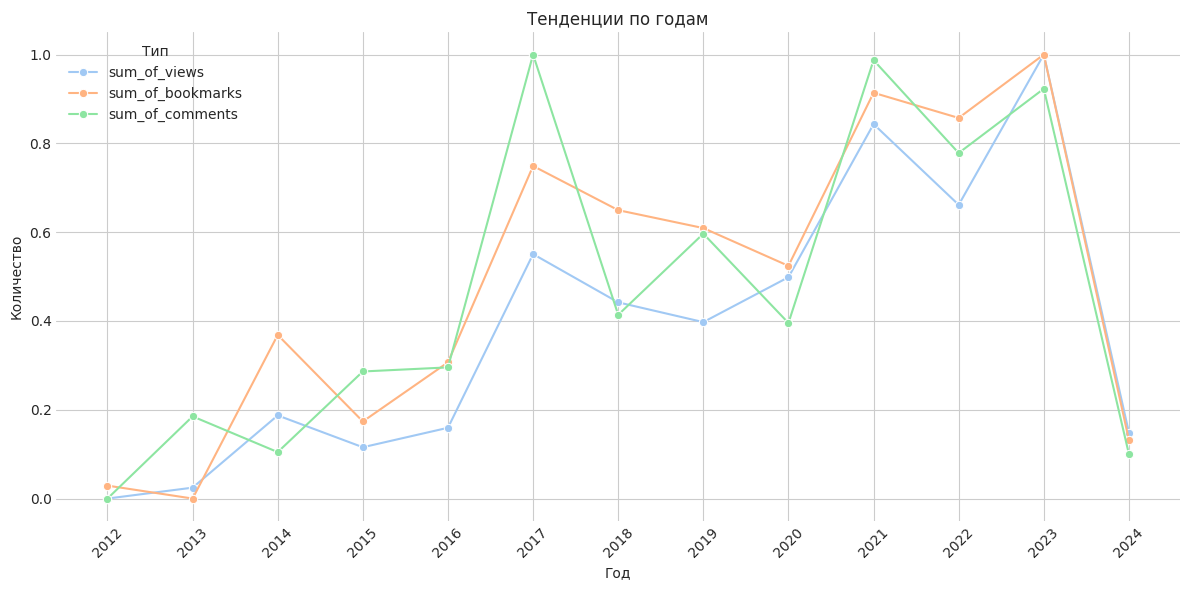

In [167]:


# Предполагается, что ваш DataFrame называется df

for col in ['sum_of_views', 'sum_of_bookmarks', 'sum_of_comments']:
    sum_by_metadata[col] = (sum_by_metadata[col] - sum_by_metadata[col].min()) / (sum_by_metadata[col].max() - sum_by_metadata[col].min())



plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Преобразование DataFrame для удобства работы с Seaborn
sum_by_metadata_melted = sum_by_metadata.melt('year', var_name='Type', value_name='Count')

sns.lineplot(x='year', y='Count', hue='Type', data=sum_by_metadata_melted, marker='o')

ax = plt.gca()  # Получаем текущие оси
ax.xaxis.set_major_locator(MultipleLocator(1))

plt.title('Тенденции по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.legend(title='Тип')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Работа с времянными рядами

In [2]:
import sys
print(sys.executable)
print(sys.path)

/usr/bin/python3
['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dasha/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


In [5]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
habr_metadata_ts = habr_metadata.set_index('time')

<Axes: xlabel='time', ylabel='views'>

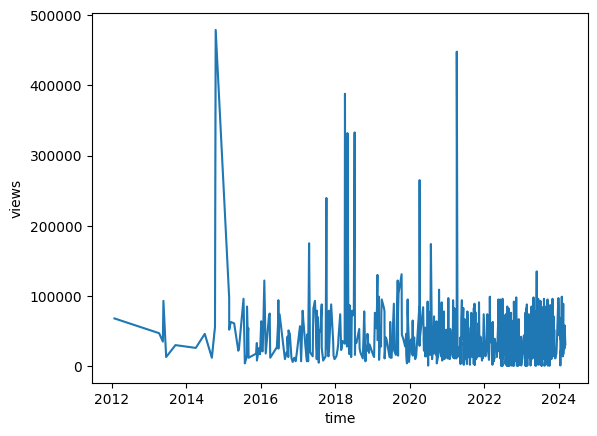

In [70]:
sns.lineplot(data = habr_metadata_ts, x= habr_metadata_ts.index, y =habr_metadata_ts['views'])

In [7]:
habr_metadata.to_csv('habr_metadata.csv')
sum_by_metadata_melted.to_csv('sum_by_metadata_melted.csv')

NameError: name 'habr_metadata' is not defined

# Работа с топик моделированием 

In [2]:
import gensim


import ast

# Чтение CSV-файла с преобразованием строк в списки
# habr_metadata = pd.read_csv('habr_metadata.csv', converters={'title_lemma': ast.literal_eval, 'tags_lemma': ast.literal_eval, 'lemma_hub': ast.literal_eval})

In [36]:
list_of_title = habr_metadata['title_lemma'].tolist()

In [37]:
gensim_dictionary = gensim.corpora.Dictionary(list_of_title)
gensim_dictionary.filter_extremes(no_above=0.15, no_below=15)
gensim_dictionary.compactify()

In [38]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in list_of_title]

In [45]:
lda_10 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=6, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

In [40]:
lda_10.print_topics()

[(0,
  '0.316*"airflow" + 0.189*"сообщение" + 0.138*"архитектура" + 0.100*"обзор" + 0.084*"streaming" + 0.064*"etl" + 0.052*"работа" + 0.026*"данных" + 0.002*"помощь" + 0.002*"использование"'),
 (1,
  '0.260*"данных" + 0.209*"часть" + 0.139*"обработка" + 0.085*"система" + 0.067*"помощь" + 0.066*"база" + 0.063*"rabbitmq" + 0.032*"sql" + 0.028*"etl" + 0.028*"streaming"'),
 (2,
  '0.281*"data" + 0.161*"использование" + 0.125*"big" + 0.118*"больший" + 0.109*"spring" + 0.097*"данных" + 0.075*"streams" + 0.004*"приложение" + 0.003*"python" + 0.003*"java"'),
 (3,
  '0.180*"помощь" + 0.179*"java" + 0.177*"приложение" + 0.172*"кластер" + 0.111*"разработчик" + 0.070*"sql" + 0.036*"rabbitmq" + 0.024*"streams" + 0.010*"данных" + 0.005*"часть"'),
 (4,
  '0.284*"kubernetes" + 0.199*"курс" + 0.156*"работа" + 0.140*"инструмент" + 0.138*"python" + 0.019*"data" + 0.011*"airflow" + 0.011*"разработчик" + 0.005*"данных" + 0.004*"использование"')]

In [41]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_10,
                                     texts = list_of_title,
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.48262825154330374


In [43]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y — значение 
    метрики
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param max: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show() 

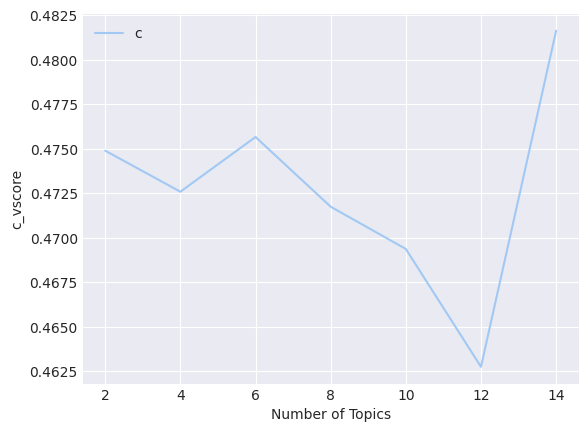

In [44]:
coherence_score(dictionary=gensim_dictionary, corpus=corpus, texts=list_of_title, start=2, max=15, step=2, measure="c_v")

/tmp/ipykernel_1198/246756939.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_1198/246756939.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_1198/246756939.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_1198/246756939.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'],

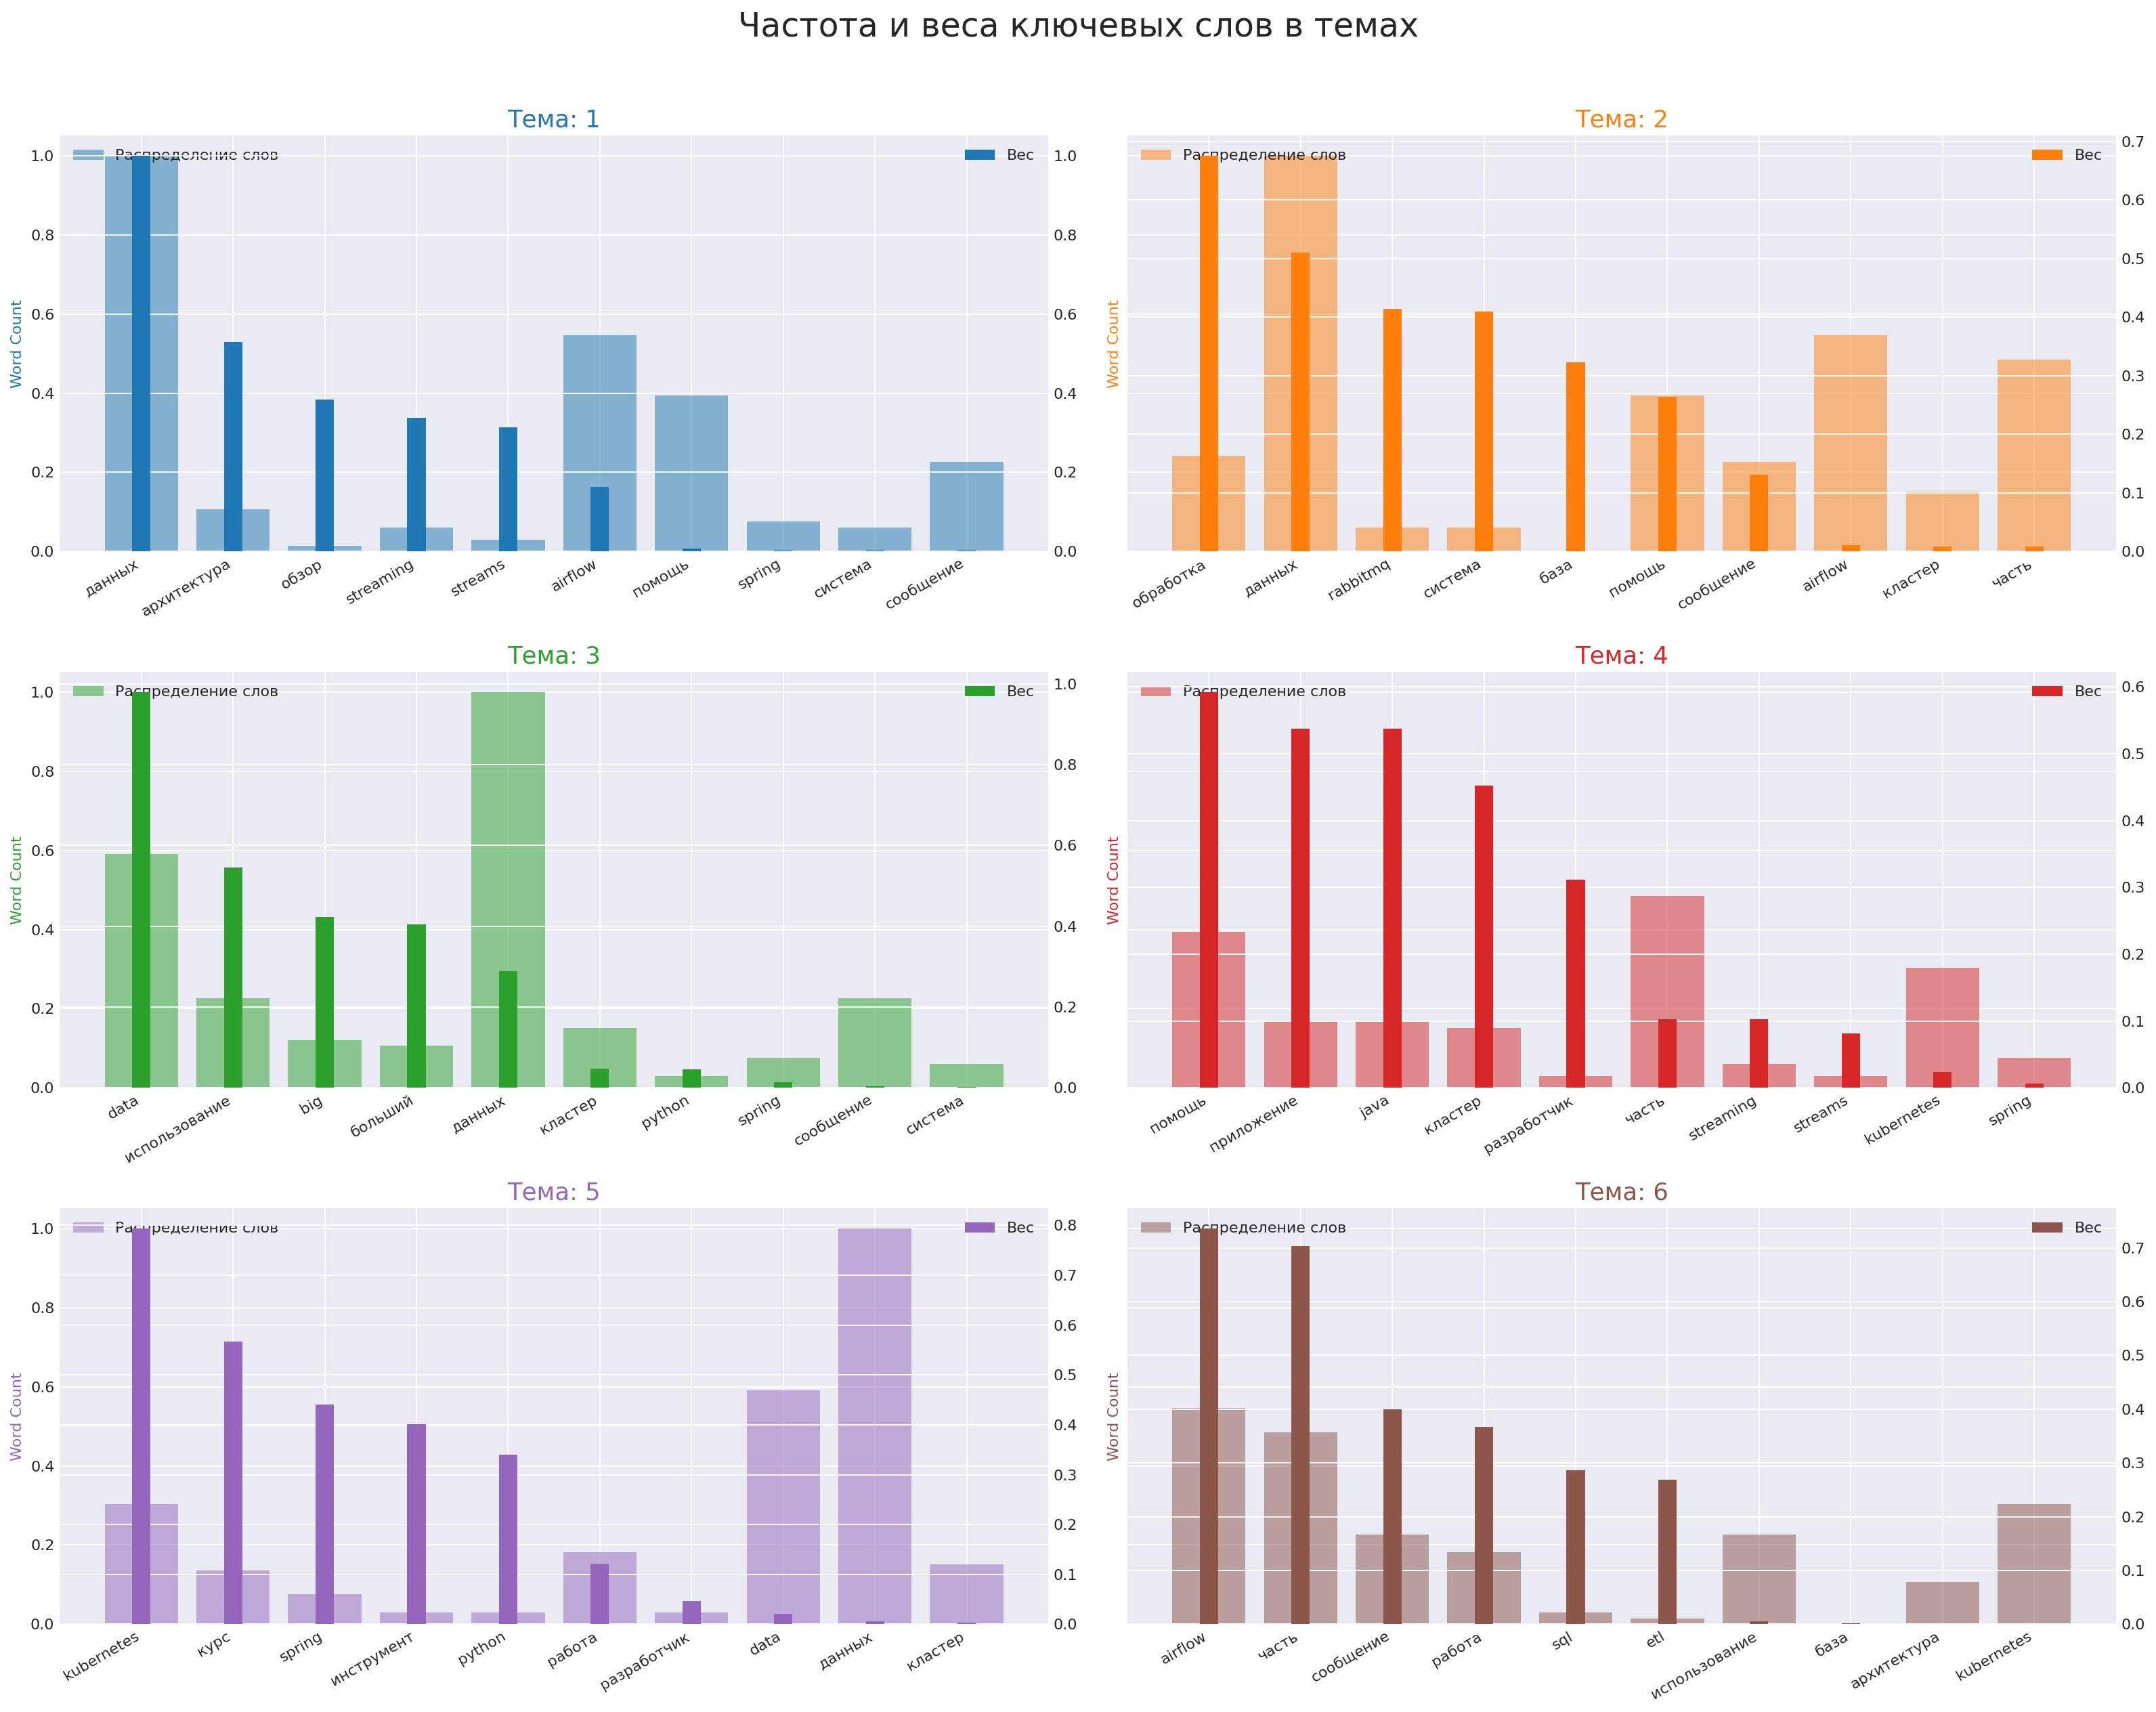

In [46]:
from collections import Counter
import matplotlib.colors as mcolors
topics = lda_10.show_topics(formatted=False)
data_flat = [w for w_list in list_of_title for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

for col in ['word_count', 'importance']:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(20,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.8, alpha=0.5, label='Распределение слов')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Вес')
    ax.set_ylabel('Word Count', color=cols[i])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Тема: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Частота и веса ключевых слов в темах', fontsize=22, y=1.05)
plt.show()